# Importing Module and define directories

In [1]:
%matplotlib inline
project_dir = '../../'
data_dir = project_dir + 'data/'

import sys
sys.path.append(project_dir + 'NN/')

import numpy as np
import importlib
import json
import time
import matplotlib.pyplot as plt
import MLP
import layer
importlib.reload(MLP)
importlib.reload(layer)
from MLP import MLP, MLP_w
from utils.preprocessing import split,StandardScaler, MinMaxScaler, k_fold_gen

from utils.regressor import regressor
from utils.trick_output import lin_sin_lin, trick_params
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble
from utils.losses import MEE
import utils.results
importlib.reload(utils.results)
from utils.results import plot_results, output_correlations


#xavier weight inizialization
def xavier(structure):
    start=np.zeros(len(structure))
    for idx,num in enumerate(structure):
        if idx==0:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx])
        else:
            start[idx]=np.sqrt(6)/np.sqrt(structure[idx-1]+structure[idx])
    return list(start)


# Fit the curve with all data

In [2]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler(kind="vector")
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)


other_output= labels[:,0]
lin_output= labels[:,1]

x = np.copy(lin_output)
y = np.copy(other_output)

used_data = np.column_stack((data, labels))

xx = np.linspace(np.min(x), np.max(x), 1000)
params = trick_params(norm_name = 'vecstd')

reg = regressor()
reg.fit(x, y, lin_sin_lin, params)
popt_sin = reg.best_params

# fig, axs = plt.subplots(1, 2, figsize = (10, 3))
# axs[0].plot(xx,lin_sin_lin(xx,*popt_sin))
# axs[0].scatter(x, y, s = 5, label ='real', alpha = 0.3, c='orange')
# axs[0].set_title('fit func vs data')
# axs[1].scatter(x, y-lin_sin_lin(x,*popt_sin), s = 5)
# axs[1].set_title('residual')
# plt.show()
# RMS = np.sqrt(np.sum((y-lin_sin_lin(x,*popt_sin))**2))
# print(f'RMS = {RMS} (root sum of squared residual)')

reg.reason

'kmax iteration reached'

## Try an ensemble

In [3]:
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble

In [4]:
raw_data=np.loadtxt("../../data/Data_set.txt")
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler(kind="vector")
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

frac_training=0.8
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                                        frac_training=frac_training)

In [5]:
n_candidates=5

list_dict_MLP=[{'structure':[10,5, labels.shape[-1]],
            'func':["tanh","relu","linear"],
            'starting_points':xavier([10,5,2])},

            {'structure':[10,20, labels.shape[-1]],
            'func':["tanh","tanh","linear"],
            'starting_points':xavier([10,20,2])},

            {'structure':[10,10, labels.shape[-1]],
            'func':["tanh","tanh","linear"],
            'starting_points':xavier([10,10,2])},

            {'structure':[10,10,10, labels.shape[-1]],
            'func':["tanh","tanh","tanh","linear"],
            'starting_points':xavier([10,10,10,2])}]

list_dict_train=[{'epoch':10000,
                'batch_size':-1,
                'eta':5e-4,
                'lamb':1e-6,
                'alpha':0.2,
                'nesterov':True,
                'RMSProp':True,
                'beta':0.8,
                'error_threshold':0.,
                'patience':200,
                'verbose':True,
                'n_candidate':n_candidates,
                'test_more_init':True},

                {'epoch':10000,
                'batch_size':-1,
                'eta':5e-4,
                'lamb':1e-5,
                'alpha':0.2,
                'nesterov':True,
                'RMSProp':True,
                'beta':0.75,
                'error_threshold':0.,
                'patience':300,
                'verbose':True,
                'n_candidate':n_candidates,
                'test_more_init':True},

                {'epoch':10000,
                'batch_size':-1,
                'eta':5e-4,
                'lamb':1e-7,
                'alpha':0.2,
                'nesterov':True,
                'RMSProp':True,
                'beta':0.8,
                'error_threshold':0.,
                'patience':300,
                'verbose':True,
                'n_candidate':n_candidates,
                'test_more_init':True},

                {'epoch':10000,
                'batch_size':-1,
                'eta':5e-4,
                'lamb':1e-6,
                'alpha':0.2,
                'nesterov':True,
                'RMSProp':True,
                'beta':0.75,
                'error_threshold':0.,
                'patience':300,
                'verbose':True,
                'n_candidate':n_candidates,
                'test_more_init':True}]


## K - Fold Ensemble

In [29]:
from joblib import Parallel, delayed

mypath = '../report/json/'
file = mypath + 'all_dict.json'

with open(file) as json_file:
    grid_results = json.load(json_file)

top_idx = [0, 1, 3, 4]
k = 4
bootstrap=False
N_ensamble=5
n_jobs = k

tr_kfold = np.array([])
val_kfold = np.array([])
Mse_cand = np.array([])

def single_fold_train(TR_set, VL_set, TR_lab, VL_lab):

    bagg = bagging_ensemble(N_ensamble)

    for idx in top_idx:
        best_model_dict = grid_results[idx]
        dict_model = best_model_dict['model']
        dict_train = best_model_dict['train']
        dict_train['verbose'] = False
        dict_train['patience'] = 300
        bagg.train(TR_set, TR_lab , VL_set, VL_lab, MLP_w, dict_model, 
                   dict_train, bootstrap = bootstrap)

    # predict 
    pred_tr = bagg.predict(TR_set, func=lin_sin_lin, param=popt_sin)
    pred_val = bagg.predict(VL_set, func=lin_sin_lin, param=popt_sin)

    # inverse transform of all
    ori_lab_tr = norm_labels.inverse_transform(TR_lab)
    ori_lab_val = norm_labels.inverse_transform(VL_lab)
    ori_pred_tr = norm_labels.inverse_transform(pred_tr)
    ori_pred_val = norm_labels.inverse_transform(pred_val)

    # compute errors
    tr_Err = MEE(ori_lab_tr, ori_pred_tr)
    val_Err = MEE(ori_lab_val, ori_pred_val)
  
    return tr_Err, val_Err

list_errors = Parallel(n_jobs = n_jobs, backend='multiprocessing')(
    delayed(single_fold_train)(*d) for d in k_fold_gen(data, labels, k = k))

0/50/5
0/5
0/5

1/5
1/5
1/5
1/5
2/5
2/5
3/5
3/5
2/5
2/5
4/5
4/5
5/10
5/10
3/5
3/5
6/10
4/5
4/5
6/10
7/10
5/10
7/10
5/10
8/10
6/10
8/10
6/10
9/10
9/10
10/15
7/10
7/10
10/15
11/15
12/15
11/15
8/10
8/10
13/15
12/15
14/15
13/15
9/10
9/10
15/20
14/15
10/15
10/15
16/20
15/20
17/20
11/15
16/20
11/15
18/20
17/20
12/15
19/20
13/15
18/20
12/15
14/15
13/15
19/20
15/20
14/15
15/20
16/20
16/20
17/20
17/20
18/20
18/20
19/20
19/20


In [31]:
tr_Err  = np.array([ee[0] for ee in list_errors])
val_Err = np.array([ee[1] for ee in list_errors])
mean_tr = np.mean(tr_Err); std_tr = np.std(tr_Err)
mean_val = np.mean(val_Err); std_val = np.std(val_Err)
print('Result of k-fold on ensemble')
print(f'train error: {mean_tr:.3f} +- {std_tr:.3f}')
print(f'val error: {mean_val:.3f} +- {std_val:.3f}')

train error: 0.963 +- 0.023
val error: 1.070 +- 0.032


# Performance evaluation on test set

In [40]:
raw_test=np.loadtxt("../../data/Test_set.txt")
test_data = raw_test[:,:10] ; test_labels = raw_test[:,-2:]
test_data = norm_data.transform(test_data)

In [41]:
import ensemble
importlib.reload(ensemble)
from ensemble import bagging_ensemble
bagg_test_predict=bagg.predict(test_data,func=lin_sin_lin, param=popt_sin)
bagg_test_predict=norm_labels.inverse_transform(bagg_test_predict)
MEE(bagg_test_predict, test_labels)

1.0705400735536208

# Retrain the ensambling on all data

In [43]:
raw_data=np.loadtxt("../../data/TR.csv",delimiter=",")[:,1:]
data = raw_data[:,:10] ; labels = raw_data[:,-2:]
norm_data = StandardScaler()
norm_labels = StandardScaler(kind="vector")
data = norm_data.fit_transform(data)
labels = norm_labels.fit_transform(labels)

In [45]:
## PROBLEMA::: NON c'è validation, la patience non si può più usare
#come is ferma il training? hold out per me, così stiamo tranquilli e vediamo di nuovo i grafici..
frac_training=0.9
input_data, val_data, train_labels, val_labels=split(data, labels,kind="hold_out",
                                                        frac_training=frac_training)
top_idx = [0, 1, 3, 4]
k = 4
bootstrap=False
N_ensamble=5
bagg = bagging_ensemble(N_ensamble)

for idx in top_idx:
    best_model_dict = grid_results[idx]
    dict_model = best_model_dict['model']
    dict_train = best_model_dict['train']
    dict_train['verbose'] = True
    dict_train['patience'] = 300
    input_data, val_data, train_labels, val_labels,
    bagg.train(input_data, train_labels , val_data, val_labels, MLP_w, dict_model, 
               dict_train, bootstrap = bootstrap)

0/5
Epoch 2612:  [train MEE = 0.1410]  [val MEE = 0.1520]                              
Elapsed time: 7.216306686401367 s
Epoch 2926:  [train MEE = 0.1441]  [val MEE = 0.1605]                              
Elapsed time: 7.948347091674805 s
Epoch 3837:  [train MEE = 0.1474]  [val MEE = 0.1591]                              
Elapsed time: 10.996565341949463 s
1/5
Epoch 2923:  [train MEE = 0.1425]  [val MEE = 0.1511]                              
Elapsed time: 7.944103240966797 s
Epoch 2431:  [train MEE = 0.1471]  [val MEE = 0.1660]                              
Elapsed time: 6.616645574569702 s
Epoch 2818:  [train MEE = 0.1439]  [val MEE = 0.1563]                              
Elapsed time: 8.050907373428345 s
2/5
Epoch 3413:  [train MEE = 0.1461]  [val MEE = 0.1541]                              
Elapsed time: 9.534284591674805 s
Epoch 2230:  [train MEE = 0.1525]  [val MEE = 0.1682]                              
Elapsed time: 6.442550182342529 s
Epoch 3649:  [train MEE = 0.1412]  [val MEE

Epoch 1487:  [train MEE = 0.1477]  [val MEE = 0.1523]                              
Elapsed time: 7.142159461975098 s
Epoch 1099:  [train MEE = 0.1507]  [val MEE = 0.1569]                              
Elapsed time: 5.1472601890563965 s


In [46]:
bagg.prune_ensemble

Pruned 1/20 classifier


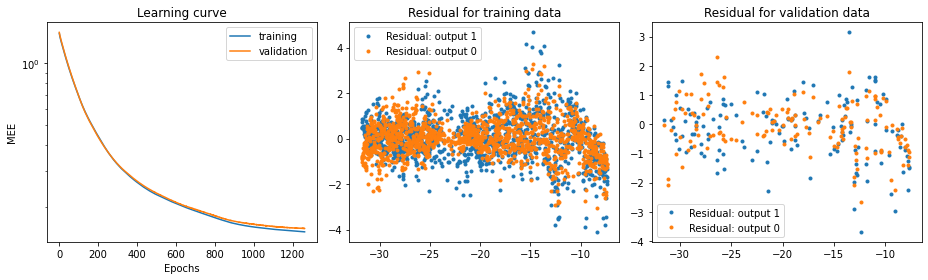

final train error: 0.9951294170910928
final val error: 1.065918200901084


In [50]:
import utils.results
importlib.reload(utils.results)
from utils.results import plot_results, output_correlations

plot_results(bagg, input_data, val_data, train_labels, val_labels,
             func = lin_sin_lin, func_args = popt_sin, mean_fit = True,
             norm = norm_labels.inverse_transform,
             sortidx = True)

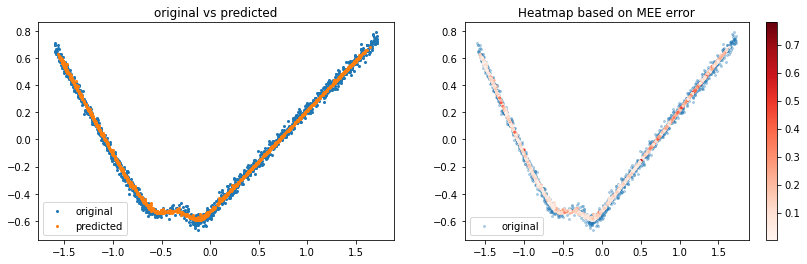

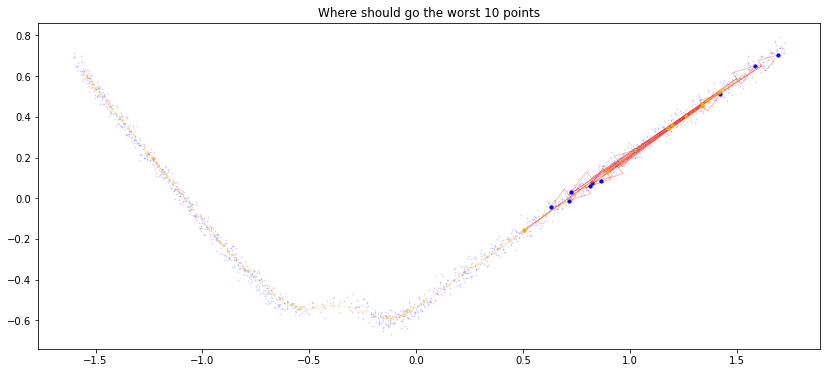

[1057  867 1197  474 1166 1104  452  642   52  663]


In [51]:
w_worst = output_correlations(bagg, input_data, train_labels, plot_arrow_worse = 10,
                    fit_func = lin_sin_lin, func_args = popt_sin
                   )

print(w_worst)

# Blind test set prediction

In [47]:
blind_data=np.loadtxt("../../data/TS.csv",delimiter=",")[:,1:]
blind_data = norm_data.fit_transform(blind_data)
out_prediction = norm_labels.inverse_transform(bagg.predict(blind_data, func=lin_sin_lin, param=popt_sin))

In [48]:
out_matrix=np.c_[np.arange(1,len(out_prediction)+1).astype(int),out_prediction]
team_name="zio_pino"
file_path=data_dir+f'{team_name}_ML-CUP21-TS.csv'
with open(file_path,'w',newline='') as file:
    file.write(f"#Piero Viscone, Edoardo Gabrielli, Adriano Del Vincio\n")
    file.write(f"#{team_name}\n")
    file.write(f"#ML-CUP21 v1\n")
    file.write(f"#4 Gennaio 2022\n")
    np.savetxt(file,out_matrix,delimiter=",",fmt="%i,%f,%f")

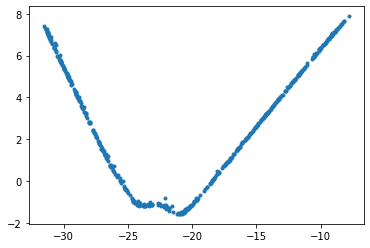

In [49]:
plt.plot(out_prediction[:,1],out_prediction[:,0],'.')